### <font color='blue'>**Data Exploration + XGBoost starter model**
    Pulled from Eric's notebook


In [39]:
import random
import pandas as pd
import numpy as np
import os
from tqdm import tqdm

from xgboost import XGBClassifier
import sklearn
from sklearn.metrics import accuracy_score, precision_recall_curve

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from collections import defaultdict

In [18]:
class Dataset:
    def __init__(self, pep_df, min_timepoints_per_patient=2):
        '''
        pep_df should be the pep_reduced_intensity_df we created above
        This dataset will only include patients with at least `min_timepoints_per_patient` timepoints
        '''
        self.pep_df = pep_df
        
        self.patient_x_timepoints = {} # patient id -> [timepoints available for this patient id, as an int array]
        
        self.data = {} # patient id -> [array of timepoint vectors]
        for patient_idx in range(1, 58+1):
            patient_timepoint_vectors = []
            patient_timepoints = []
            for timepoint in range(1, 7+1):
                try:
                    # We replace all nans with zeros using np.nan_to_num
                    patient_timepoint_vector = np.nan_to_num(self.pep_df[f"Patient_{patient_idx:02d}.Timepoint_{timepoint:01d}"].values)
                    patient_timepoint_vectors.append(patient_timepoint_vector)
                    patient_timepoints.append(timepoint)
                except:
                    # This patient timepoint doesnt exist in the data
                    pass
            
            # If this patient had at least `min_timepoints_per_patient` timepoints, then include this patient id
            if len(patient_timepoint_vectors) >= min_timepoints_per_patient:
                self.data[patient_idx] = patient_timepoint_vectors
                self.patient_x_timepoints[patient_idx] = patient_timepoints
                
    @staticmethod
    def prepare_df(filepath):
        df = pd.read_csv(filepath, sep="\t")
        
        # only keep the Patient_x.Timepoint_y formatted columns
        df = df.iloc[:, :667]
        
        # Remove all _unmod columns
        df = df[df.columns.drop(list(df.filter(regex='.\_unmod')))]
        
        # Convert the string abundance numbers into ints for all patient timepoint cols
        def convert_to_number(val):
            if isinstance(val, str):
                return int(val.replace(",","").strip())
            return val

        for patient_timepoint_col in df.columns.values[32:]:
            df[patient_timepoint_col] = df[patient_timepoint_col].apply(convert_to_number)
            df[patient_timepoint_col] = df[patient_timepoint_col].astype(float)
        
        return df
    
    @classmethod
    def from_file(cls, filepath, *args, **kwargs):
        pip_df = cls.prepare_df(filepath)
        return cls(pip_df, *args, **kwargs)
    
    def get_patient_level_timepoint_vectors(self, patient_id):
        assert patient_id in self.data and patient_id in self.patient_x_timepoints
        
        timepoint_difference_x_timepoint_vecs = defaultdict(list)
        
        patient_timepoint_vecs = self.data[patient_id]
        for first_timepoint_idx in range(len(patient_timepoint_vecs) - 1):
            first_timepoint = self.patient_x_timepoints[patient_id][first_timepoint_idx]
            first_vec = patient_timepoint_vecs[first_timepoint_idx]
            
            for second_timepoint_idx in range(first_timepoint_idx + 1, len(patient_timepoint_vecs)):
                second_timepoint = self.patient_x_timepoints[patient_id][second_timepoint_idx]
                second_vec = patient_timepoint_vecs[second_timepoint_idx]
                
                timepoint_difference = second_timepoint - first_timepoint
                assert timepoint_difference > 0
                
                timepoint_difference_x_timepoint_vecs[timepoint_difference].append((first_vec, second_vec))
        
        return timepoint_difference_x_timepoint_vecs

    def data_generator(self, patient_ids, num_samples, peptide_indices=None, same_patient_pair_probability=0.5):
        """
        This will return a generator that will yield `num_samples` sample pairs of peptide vectors 
        (limited to only the `patient_ids` given, and the `peptide_indices` given (if none is given, then all peptides will be included))
        such that, `same_patient_pair_probability` of the time, the pair of vectors will be from the same patient (but different time points)
                
        Data samples yielded by the returned generator will be of the form:
        {
            "first_patient_idx" : ...,
            "first_patient_timepoint_vector" : ...,
            "second_patient_idx" : ...,
            "second_patient_timepoint_vector" : ...,
            "is_same_patient" : True/False
        }
        
        """
        assert same_patient_pair_probability is not None
        
        # First ensure all of the given patient ids are in out prepared dataset
        assert all(pid in self.data for pid in patient_ids), "Not all of the given patient ids are in our dataset"
        
        def data_gen():
            # This generator is used when same_patient_pair_probability is NOT None
            for _ in range(num_samples):
                
                # pick a random first patient id
                first_patient_id = random.choice(patient_ids)
                
                # pick a random timepoint vector for this first patient id
                first_patient_timepoint_vector = random.choice(self.data[first_patient_id])
                
                # decide if the second patient in our pair should be the same as the first
                is_second_patient_same = random.random() <= same_patient_pair_probability
                
                if is_second_patient_same:
                    second_patient_id = first_patient_id
                else:
                    second_patient_id = random.choice([pid for pid in patient_ids if pid != first_patient_id])
                
                # Note: In this approach, it is possible that, when the second patient = first patient,
                # They both return the same timepoint vector. but that should be okay, since this will help the model learn
                # to detect identical inputs, especially when the input to the model is the concatenated vector
                second_patient_timepoint_vector = random.choice(self.data[second_patient_id])
                
                # if peptide_indices is given, filter the vectors to only include the `peptide_indices` peptides
                if peptide_indices:
                    first_patient_timepoint_vector = first_patient_timepoint_vector[peptide_indices]
                    second_patient_timepoint_vector = second_patient_timepoint_vector[peptide_indices]
                
                yield {
                    "first_patient_id" : first_patient_id,
                    "first_patient_timepoint_vector" : first_patient_timepoint_vector,
                    "second_patient_id" : second_patient_id,
                    "second_patient_timepoint_vector" : second_patient_timepoint_vector,
                    "is_same_patient" : first_patient_id == second_patient_id
                }

        return data_gen()

In [11]:
DATA_DIR = "./Data"
DATA_TSV_FILEPATH = os.path.join(DATA_DIR, "peptidoforms_intensity", "data.tsv")

In [12]:
# Establish all random seeds
random.seed(2021)

# TODO: other libraries should be seeded here, like sklearn, torch, xgboost, etc.

### <font color='blue'>**Creating Main Dataset**

In [13]:
peptidoforms_intensity_dataset = Dataset.from_file(DATA_TSV_FILEPATH)

/Users/subby/UCSD/CSE_291C/Projects/cse291c-plasma-weightloss/venv/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (38,42,44,48,52,56,92,98,102,108,116,122,124,126,128,130,132,134,138,140,144,146,148,150,152,154,156,176,184,190,196,200,212,216,228,234,236,238,242,244,246,248,250,252,254,256,258,260,262,264,268,270,272,274,284,286,288,290,292,294,296,298,300,302,304,306,308,310,312,314,316,318,322,324,330,332,334,336,338,340,342,344,346,350,364,372,374,378,380,382,388,390,392,394,398,404,406,408,410,412,414,416,426,428,440,444,446,454,458,460,464,466,468,484,502,510,514,516,522,524,526,528,538,540,542,544,552,554,556,558,562,576,592,606,608,610,612,618,622,624,626,628,630,632,640,642,644,646,650,652,654,656,658,660,662,664,674,676,678,684,686,692,694,696,698,700,702) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [15]:
list(peptidoforms_intensity_dataset.data.keys())[0]

1

In [14]:
peptidoforms_intensity_df = peptidoforms_intensity_dataset.pep_df
peptidoforms_intensity_df.shape

(40921, 350)

---

### <font color='blue'>**Creating Train/Val/Test Datasets**
    
Train/val/test datasets will enforce the `same_patient_pair_probability = 0.5`

In [7]:
train_ratio = 0.6
val_ratio = 0.2
test_ratio = 0.2

In [8]:
# For now, we don't select a particular subset of peptides, and just use all of them.
selected_peptide_indices = None

In [9]:
train_same_patient_pair_probability = 0.5
val_same_patient_pair_probability = 0.5
test_same_patient_pair_probability = 0.5

In [10]:
# using 1k samples for train/val/test finishes fast, but may not be accurate
# so we should train with more samples (~100K train/val/test) with colab/gpu later, which would take more time
num_train_samples = 10000
num_val_samples = 10000
num_test_samples = 10000

In [11]:
all_patient_ids = list(peptidoforms_intensity_dataset.data.keys())
num_patient_ids = len(all_patient_ids)
num_patient_ids

52

In [12]:
random.shuffle(all_patient_ids)
train_patient_ids, val_patient_ids, test_patient_ids = np.split(all_patient_ids, 
                                                                [int(train_ratio * num_patient_ids), 
                                                                 int((train_ratio + val_ratio) * num_patient_ids)
                                                                ])
train_patient_ids = train_patient_ids.tolist()
val_patient_ids = val_patient_ids.tolist()
test_patient_ids = test_patient_ids.tolist()

len(train_patient_ids), len(val_patient_ids), len(test_patient_ids)

(31, 10, 11)

In [13]:
def create_data_arrays_from_generator(gen):
    """
    returns (concatX, absdiffX Y)
    
    concatX is the two input feature vectors concatenated together
    absdiffX is the abs difference between the two input feature vectors
    Y is always 1/0 if the vectors are from the same patient or not
    """    
    concatX, absdiffX, Y = [], [], []
    
    for data_input in tqdm(gen):
        concatX.append(np.hstack((data_input['first_patient_timepoint_vector'], data_input['second_patient_timepoint_vector'])).astype(int))
        absdiffX.append(np.abs(data_input['first_patient_timepoint_vector'] - data_input['second_patient_timepoint_vector']).astype(int))
        Y.append(1 if data_input['is_same_patient'] else 0)
    
    return np.array(concatX), np.array(absdiffX), np.array(Y)

In [14]:
train_data_gen = peptidoforms_intensity_dataset.data_generator(
    patient_ids=train_patient_ids, 
    num_samples=num_train_samples, 
    peptide_indices=selected_peptide_indices, 
    same_patient_pair_probability=train_same_patient_pair_probability)
concatTrainX, absDiffTrainX, trainY = create_data_arrays_from_generator(train_data_gen)

val_data_gen = peptidoforms_intensity_dataset.data_generator(
    patient_ids=val_patient_ids, 
    num_samples=num_val_samples, 
    peptide_indices=selected_peptide_indices, 
    same_patient_pair_probability=val_same_patient_pair_probability)
concatValX, absDiffValX, valY = create_data_arrays_from_generator(val_data_gen)

test_data_gen = peptidoforms_intensity_dataset.data_generator(
    patient_ids=test_patient_ids, 
    num_samples=num_test_samples, 
    peptide_indices=selected_peptide_indices, 
    same_patient_pair_probability=test_same_patient_pair_probability)
concatTestX, absDiffTestX, testY = create_data_arrays_from_generator(test_data_gen)

10000it [00:10, 999.75it/s]
10000it [00:08, 1231.38it/s]
10000it [00:07, 1356.14it/s]


In [15]:
# Sanity check that the labels are in a rough 50-50 distribution
pd.Series(trainY).value_counts()

0    5005
1    4995
dtype: int64

In [16]:
# Sanity check that the labels are in a rough 50-50 distribution
pd.Series(valY).value_counts()

1    5079
0    4921
dtype: int64

In [17]:
# Sanity check that the labels are in a rough 50-50 distribution
pd.Series(testY).value_counts()

1    5033
0    4967
dtype: int64

---

### <font color='blue'>**XGBoost model variants**</font>

The different variants we will be training are the following:

First, train 2 models where one takes in concatenated features vs. the other takes in the absolute value difference of the input feature vectors. Let the better of these 2 models (based on the lowest val loss achieved) be called model A.

Using model A, get its important feature weights, and try to train the same model architecture but only using the top k features (where k = 1, 10, 100, num_nonzeroweight_peptides_from_modelA).

Finally, using model A, also train only using peptides present in at most N patients for N = (5, 10, 20, 40).

---

**Sanity check:** Initial log loss should be around $0.69$, since $-ln(0.5) = 0.6931471806$ and there is a $0.5$ probability of same/different patient

In [20]:
from xgboost import XGBClassifier

In [21]:
modelA2 = XGBClassifier(use_label_encoder=False, max_depth=3)

In [20]:
# trained on abs difference vectors
print("Training model A2: abs difference of input feature vectors")
modelA2.fit(absDiffTrainX, trainY, eval_metric="logloss", eval_set=[(absDiffValX, valY)], verbose=True)

Training model A2: abs difference of input feature vectors
[0]	validation_0-logloss:0.52902
[1]	validation_0-logloss:0.43568
[2]	validation_0-logloss:0.35243
[3]	validation_0-logloss:0.30989
[4]	validation_0-logloss:0.26580
[5]	validation_0-logloss:0.22608
[6]	validation_0-logloss:0.20256
[7]	validation_0-logloss:0.17520
[8]	validation_0-logloss:0.15090
[9]	validation_0-logloss:0.13560
[10]	validation_0-logloss:0.12131
[11]	validation_0-logloss:0.11034
[12]	validation_0-logloss:0.09788
[13]	validation_0-logloss:0.08920
[14]	validation_0-logloss:0.07758
[15]	validation_0-logloss:0.07032
[16]	validation_0-logloss:0.06732
[17]	validation_0-logloss:0.06119
[18]	validation_0-logloss:0.05253
[19]	validation_0-logloss:0.04782
[20]	validation_0-logloss:0.04357
[21]	validation_0-logloss:0.04125
[22]	validation_0-logloss:0.03873
[23]	validation_0-logloss:0.03868
[24]	validation_0-logloss:0.03583
[25]	validation_0-logloss:0.03333
[26]	validation_0-logloss:0.03285
[27]	validation_0-logloss:0.03005

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [21]:
## Save models
modelA2.save_model('xgboost_modelA2.json')

In [22]:
# Load model
modelA2.load_model("./artifacts/xgboost_modelA2.json")

## Patient level consistency

In [24]:
patient_ids = list(peptidoforms_intensity_dataset.data.keys())
len(patient_ids)

52

In [32]:
patient_x_timepoint_diff_acccuracies = {}

for patient_id in tqdm(patient_ids):
    
    patient_timepoint_diff_accuracies = {}
    
    # patient_level_timepoint_diff_vecs is:
    # timepoint diff -> list of (vec1, vec2) pairs
    patient_timepoint_diff_vecs = peptidoforms_intensity_dataset.get_patient_level_timepoint_vectors(patient_id)
    
    for timepoint_diff, timepoint_vec_pairs in patient_timepoint_diff_vecs.items():
        num_correct = 0
        
        for (vec1, vec2) in timepoint_vec_pairs:
            model_input = np.abs(vec1 - vec2).astype(int).reshape((1, -1))
            model_prediction = round(modelA2.predict(model_input)[0])
            is_correct_prediction = (model_prediction == 1)
            if is_correct_prediction:
                num_correct += 1
        
        timepoint_diff_acc = num_correct / len(timepoint_vec_pairs)
        patient_timepoint_diff_accuracies[timepoint_diff] = timepoint_diff_acc
        
    patient_x_timepoint_diff_acccuracies[patient_id] = patient_timepoint_diff_accuracies

100%|██████████| 52/52 [00:10<00:00,  4.86it/s]


In [33]:
patient_x_timepoint_diff_acccuracies

{1: {1: 1.0, 2: 1.0, 3: 1.0, 4: 1.0, 5: 1.0, 6: 1.0},
 2: {1: 1.0, 2: 1.0, 3: 1.0, 4: 1.0, 5: 1.0, 6: 1.0},
 3: {1: 1.0, 2: 1.0, 3: 0.75, 4: 1.0, 5: 1.0, 6: 1.0},
 5: {1: 1.0, 2: 1.0, 3: 1.0, 4: 1.0, 5: 1.0, 6: 1.0},
 6: {1: 1.0, 2: 1.0, 3: 1.0, 4: 1.0, 5: 1.0, 6: 1.0},
 7: {1: 1.0, 2: 1.0, 3: 1.0, 4: 1.0, 5: 1.0, 6: 1.0},
 8: {1: 1.0, 2: 1.0, 3: 1.0, 4: 1.0, 5: 1.0, 6: 1.0},
 9: {1: 1.0, 2: 1.0, 3: 1.0, 4: 1.0, 5: 1.0, 6: 1.0},
 10: {1: 1.0, 2: 1.0, 3: 1.0, 4: 1.0, 5: 1.0, 6: 1.0},
 11: {1: 1.0, 2: 1.0, 3: 1.0, 4: 1.0, 5: 1.0, 6: 1.0},
 12: {1: 1.0, 2: 1.0, 3: 1.0, 4: 1.0, 5: 1.0, 6: 1.0},
 14: {1: 1.0, 2: 1.0, 3: 1.0, 4: 1.0, 5: 1.0, 6: 1.0},
 15: {1: 1.0, 2: 1.0, 3: 1.0, 4: 1.0, 5: 1.0, 6: 1.0},
 16: {1: 1.0, 2: 1.0, 3: 1.0, 4: 1.0, 5: 1.0, 6: 1.0},
 17: {1: 1.0, 2: 1.0, 3: 1.0, 4: 1.0, 5: 1.0, 6: 1.0},
 19: {1: 1.0, 2: 1.0, 3: 1.0, 4: 1.0, 5: 1.0, 6: 1.0},
 20: {1: 1.0, 2: 1.0, 3: 1.0, 4: 1.0, 5: 1.0, 6: 1.0},
 21: {1: 1.0, 2: 1.0, 3: 1.0, 4: 1.0, 5: 1.0, 6: 1.0},
 22: {1: 0.833333

In [35]:
possible_timepoint_diffs = list(range(1, 6+1))

timepoint_diff_x_patient_accs = defaultdict(list)

for patient_idx, patient_timepoint_accs in patient_x_timepoint_diff_acccuracies.items():
    for timepoint_diff, timepoint_acc in patient_timepoint_accs.items():
        timepoint_diff_x_patient_accs[timepoint_diff].append(timepoint_acc)

In [41]:
timepoint_diff_x_patient_accs

defaultdict(list,
            {1: [1.0,
              1.0,
              1.0,
              1.0,
              1.0,
              1.0,
              1.0,
              1.0,
              1.0,
              1.0,
              1.0,
              1.0,
              1.0,
              1.0,
              1.0,
              1.0,
              1.0,
              1.0,
              0.8333333333333334,
              1.0,
              1.0,
              1.0,
              1.0,
              1.0,
              1.0,
              1.0,
              1.0,
              1.0,
              1.0,
              1.0,
              1.0,
              1.0,
              1.0,
              1.0,
              1.0,
              1.0,
              1.0,
              1.0,
              1.0,
              1.0,
              1.0,
              1.0,
              1.0,
              1.0,
              1.0,
              1.0,
              1.0,
              1.0,
              1.0,
              1.0,
              

In [40]:
sns.load_dataset('iris').head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [43]:
patient_level_timepoint_df_records = []
for timepoint_diff, timepoint_accs_across_all_patients in timepoint_diff_x_patient_accs.items():
    for timepoint_acc in timepoint_accs_across_all_patients:
        patient_level_timepoint_df_records.append({"timepoint_difference" : timepoint_diff, "accuracy" : timepoint_acc})


patient_level_timepoint_df = pd.DataFrame.from_records(patient_level_timepoint_df_records)
patient_level_timepoint_df.tail()

,timepoint_difference,accuracy
261,6,1.0
262,6,1.0
263,6,1.0
264,6,1.0
265,6,1.0


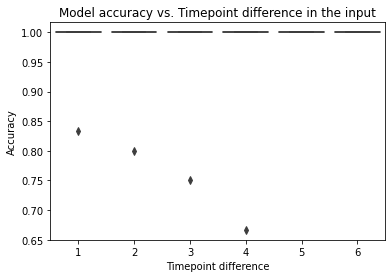

In [49]:
sns.boxplot( x=patient_level_timepoint_df["timepoint_difference"], y=patient_level_timepoint_df["accuracy"])
plt.xlabel("Timepoint difference")
plt.ylabel("Accuracy")
plt.title("Model accuracy vs. Timepoint difference in the input")
plt.show()

### Model A2 - metrics

In [42]:
from sklearn.metrics import accuracy_score, precision_recall_curve, average_precision_score

In [22]:
# helper method to print basic model metrics
def metrics(y_true, y_pred):
    print('Confusion matrix:\n', confusion_matrix(y_true, y_pred))
    print('\nReport:\n', classification_report(y_true, y_pred))

In [43]:
def print_model_metrics(model, model_input_format, mode, peptide_indices=None):
    assert model_input_format in ("concat", "abs_diff")
    assert mode in ("train", "val", "test")
    
    if peptide_indices is None:
        x_s = {
            "train" : {
                "concat" : concatTrainX,
                "abs_diff" : absDiffTrainX
            },
            "val" : {
                "concat" : concatValX,
                "abs_diff" : absDiffValX
            },
            "test" : {
                "concat" : concatTestX,
                "abs_diff" : absDiffTestX
            }
        }
    else:
        x_s = {
            "train" : {
                "concat" : concatTrainX,
                "abs_diff" : absDiffTrainX[:,peptide_indices]
            },
            "val" : {
                "concat" : concatValX,
                "abs_diff" : absDiffValX[:,peptide_indices]
            },
            "test" : {
                "concat" : concatTestX,
                "abs_diff" : absDiffTestX[:,peptide_indices]
            }
        }


    y_s = {
        "train" : trainY,
        "val" : valY,
        "test" : testY
    }
    
    x = x_s[mode][model_input_format]
    y = y_s[mode]
        
    pred_scores = model.predict(x)
    preds = [round(pred_score) for pred_score in pred_scores]
    
    metrics(y, preds)
    acc = accuracy_score(y, preds)
    
    ap = average_precision_score(y, pred_scores)
    
    print (f"{mode} accuracy: {acc}")
    print (f"{mode} average precision: {ap}")
    
    precision, recall, thresholds = precision_recall_curve(y, pred_scores)
    
    # plotting below taken from: 
    # https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-imbalanced-classification/
    
    # calculate the no skill line as the proportion of the positive class
    no_skill = len(y[y==0]) / len(y)
    
    # plot the no skill precision-recall curve
    plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='Trivial model')
    
    # plot the model precision-recall curve
    plt.plot(recall, precision, marker='.', label='XGBoost model')
    
    # axis labels
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    
    # show the legend
    plt.legend()
    
    # show the plot
    plt.show()

#### Model A2

Confusion matrix:
 [[5005    0]
 [   0 4995]]

Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      5005
           1       1.00      1.00      1.00      4995

    accuracy                           1.00     10000
   macro avg       1.00      1.00      1.00     10000
weighted avg       1.00      1.00      1.00     10000

train accuracy: 1.0
train average precision: 1.0


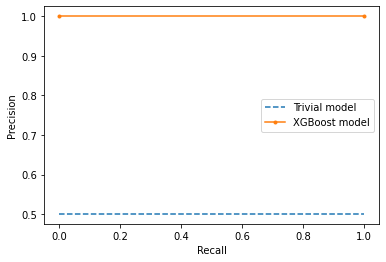

In [44]:
print_model_metrics(modelA2, "abs_diff", "train")

Confusion matrix:
 [[4918    3]
 [  42 5037]]

Report:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00      4921
           1       1.00      0.99      1.00      5079

    accuracy                           1.00     10000
   macro avg       1.00      1.00      1.00     10000
weighted avg       1.00      1.00      1.00     10000

val accuracy: 0.9955
val average precision: 0.9953403397744213


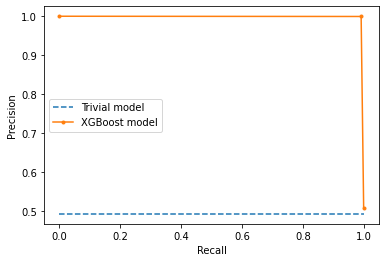

In [45]:
print_model_metrics(modelA2, "abs_diff", "val")

Confusion matrix:
 [[4967    0]
 [  35 4998]]

Report:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00      4967
           1       1.00      0.99      1.00      5033

    accuracy                           1.00     10000
   macro avg       1.00      1.00      1.00     10000
weighted avg       1.00      1.00      1.00     10000

test accuracy: 0.9965
test average precision: 0.9965458970792768


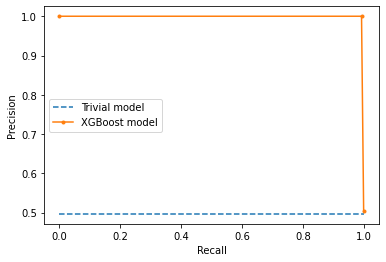

In [46]:
print_model_metrics(modelA2, "abs_diff", "test")

### Training model A2 using only the top k peptides (k = 1, 5, 10, 25, 50, num_peptides_with_nonzero_weight)

In [28]:
ft = modelA2.feature_importances_
np.save("modelA2_feature_importances.npy", ft)

In [27]:
ft = np.load("./artifacts/modelA2_feature_importances.npy")

In [28]:
num_peptides_with_nonzero_weight = len(ft[ft > 0]) # count number of peptides with a non-zero weight
num_peptides_with_nonzero_weight

186

In [29]:
num_unique_peptides = len(peptidoforms_intensity_df)
assert num_unique_peptides == len(ft)

In [30]:
top_peptidoform_indices = ft.argsort()[::-1]

In [31]:
# lets get some of the most important (top 10) peptide indices
top_peptidoform_indices[:10]

array([3074, 1854, 1549, 1845, 6518, 3600, 4682, 2028, 3143, 3205])

In [32]:
# weights of the top 10 most important peptides
ft[top_peptidoform_indices[:10]]

array([0.22851141, 0.07314852, 0.06615254, 0.04299809, 0.04167254,
       0.03468453, 0.02914159, 0.02787849, 0.02349349, 0.02179071],
      dtype=float32)

In [33]:
def isolate_peptide_indices(X, peptide_indices):
    # use only the given peptide indices from the given X matrix, where X is a list of all the absolute difference vectors
    # since this model format performed the best, when compared to the concatenated vector representation
    return X[:,peptide_indices]

In [34]:
def try_model_on_top_k_peptides(k_values=(1, 5, 10, 25, 50, num_peptides_with_nonzero_weight)):
    
    topkpeptide_models = []
    for k in k_values:
        print ("="*50)
        print (f"K value: {k}")
        print ("="*50)
        
        k_trainX = isolate_peptide_indices(absDiffTrainX, top_peptidoform_indices[:k])
        k_trainY = trainY
        
        k_valX = isolate_peptide_indices(absDiffValX, top_peptidoform_indices[:k])
        k_valY = valY
        
        topk_model = XGBClassifier(use_label_encoder=False, max_depth=3)
        topk_model.fit(k_trainX, k_trainY, eval_metric="logloss", eval_set=[(k_valX, k_valY)], verbose=True)
        topk_model.save_model(f"xgboost_modelA2_top{k}_peptides.json")
        topkpeptide_models.append(topk_model)
        
        print_model_metrics(topk_model, "abs_diff", "train", peptide_indices=top_peptidoform_indices[:k])
        print_model_metrics(topk_model, "abs_diff", "val", peptide_indices=top_peptidoform_indices[:k])
        print_model_metrics(topk_model, "abs_diff", "test", peptide_indices=top_peptidoform_indices[:k])

        print ("\n\n")
    
    return topkpeptide_models

K value: 1
[0]	validation_0-logloss:0.59605
[1]	validation_0-logloss:0.54817
[2]	validation_0-logloss:0.52124
[3]	validation_0-logloss:0.50950
[4]	validation_0-logloss:0.50411
[5]	validation_0-logloss:0.50058
[6]	validation_0-logloss:0.50211
[7]	validation_0-logloss:0.50021
[8]	validation_0-logloss:0.50231
[9]	validation_0-logloss:0.50872
[10]	validation_0-logloss:0.50898
[11]	validation_0-logloss:0.51092
[12]	validation_0-logloss:0.51115
[13]	validation_0-logloss:0.51270
[14]	validation_0-logloss:0.51437
[15]	validation_0-logloss:0.51560
[16]	validation_0-logloss:0.51638
[17]	validation_0-logloss:0.51771
[18]	validation_0-logloss:0.51959
[19]	validation_0-logloss:0.52223
[20]	validation_0-logloss:0.52351
[21]	validation_0-logloss:0.52434
[22]	validation_0-logloss:0.52555
[23]	validation_0-logloss:0.52516
[24]	validation_0-logloss:0.52603
[25]	validation_0-logloss:0.52714
[26]	validation_0-logloss:0.52603
[27]	validation_0-logloss:0.52688
[28]	validation_0-logloss:0.52902
[29]	validati

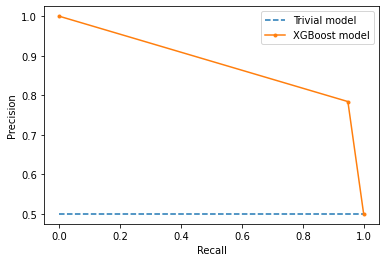

Confusion matrix:
 [[3652 1269]
 [ 989 4090]]

Report:
               precision    recall  f1-score   support

           0       0.79      0.74      0.76      4921
           1       0.76      0.81      0.78      5079

    accuracy                           0.77     10000
   macro avg       0.78      0.77      0.77     10000
weighted avg       0.77      0.77      0.77     10000

val accuracy: 0.7742


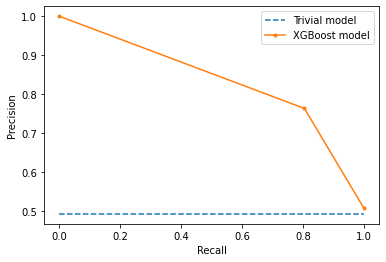

Confusion matrix:
 [[3319 1648]
 [1135 3898]]

Report:
               precision    recall  f1-score   support

           0       0.75      0.67      0.70      4967
           1       0.70      0.77      0.74      5033

    accuracy                           0.72     10000
   macro avg       0.72      0.72      0.72     10000
weighted avg       0.72      0.72      0.72     10000

test accuracy: 0.7217


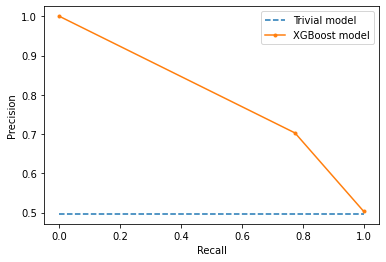




K value: 5
[0]	validation_0-logloss:0.53197
[1]	validation_0-logloss:0.45496
[2]	validation_0-logloss:0.38368
[3]	validation_0-logloss:0.33270
[4]	validation_0-logloss:0.31510
[5]	validation_0-logloss:0.28833
[6]	validation_0-logloss:0.28384
[7]	validation_0-logloss:0.27364
[8]	validation_0-logloss:0.25818
[9]	validation_0-logloss:0.25585
[10]	validation_0-logloss:0.25874
[11]	validation_0-logloss:0.26176
[12]	validation_0-logloss:0.26232
[13]	validation_0-logloss:0.26377
[14]	validation_0-logloss:0.26177
[15]	validation_0-logloss:0.25896
[16]	validation_0-logloss:0.26027
[17]	validation_0-logloss:0.26754
[18]	validation_0-logloss:0.26476
[19]	validation_0-logloss:0.26677
[20]	validation_0-logloss:0.27446
[21]	validation_0-logloss:0.27446
[22]	validation_0-logloss:0.27525
[23]	validation_0-logloss:0.27443
[24]	validation_0-logloss:0.27756
[25]	validation_0-logloss:0.28588
[26]	validation_0-logloss:0.28646
[27]	validation_0-logloss:0.29107
[28]	validation_0-logloss:0.29214
[29]	valid

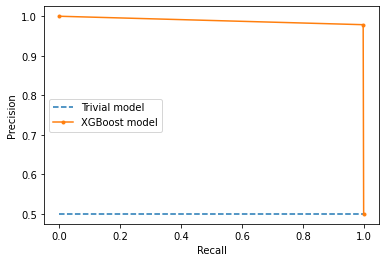

Confusion matrix:
 [[4532  389]
 [1103 3976]]

Report:
               precision    recall  f1-score   support

           0       0.80      0.92      0.86      4921
           1       0.91      0.78      0.84      5079

    accuracy                           0.85     10000
   macro avg       0.86      0.85      0.85     10000
weighted avg       0.86      0.85      0.85     10000

val accuracy: 0.8508


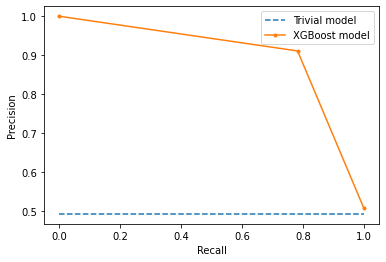

Confusion matrix:
 [[4605  362]
 [1090 3943]]

Report:
               precision    recall  f1-score   support

           0       0.81      0.93      0.86      4967
           1       0.92      0.78      0.84      5033

    accuracy                           0.85     10000
   macro avg       0.86      0.86      0.85     10000
weighted avg       0.86      0.85      0.85     10000

test accuracy: 0.8548


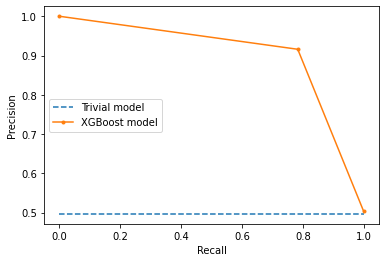




K value: 10
[0]	validation_0-logloss:0.53698
[1]	validation_0-logloss:0.41674
[2]	validation_0-logloss:0.35728
[3]	validation_0-logloss:0.30012
[4]	validation_0-logloss:0.26263
[5]	validation_0-logloss:0.23578
[6]	validation_0-logloss:0.21620
[7]	validation_0-logloss:0.19563
[8]	validation_0-logloss:0.17564
[9]	validation_0-logloss:0.16470
[10]	validation_0-logloss:0.15529
[11]	validation_0-logloss:0.15082
[12]	validation_0-logloss:0.14446
[13]	validation_0-logloss:0.13825
[14]	validation_0-logloss:0.13737
[15]	validation_0-logloss:0.13452
[16]	validation_0-logloss:0.13218
[17]	validation_0-logloss:0.13555
[18]	validation_0-logloss:0.13147
[19]	validation_0-logloss:0.12753
[20]	validation_0-logloss:0.12525
[21]	validation_0-logloss:0.12403
[22]	validation_0-logloss:0.12190
[23]	validation_0-logloss:0.12071
[24]	validation_0-logloss:0.12102
[25]	validation_0-logloss:0.11894
[26]	validation_0-logloss:0.12163
[27]	validation_0-logloss:0.11958
[28]	validation_0-logloss:0.11901
[29]	vali

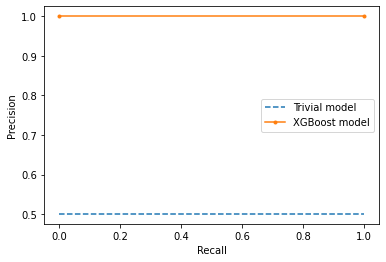

Confusion matrix:
 [[4663  258]
 [ 304 4775]]

Report:
               precision    recall  f1-score   support

           0       0.94      0.95      0.94      4921
           1       0.95      0.94      0.94      5079

    accuracy                           0.94     10000
   macro avg       0.94      0.94      0.94     10000
weighted avg       0.94      0.94      0.94     10000

val accuracy: 0.9438


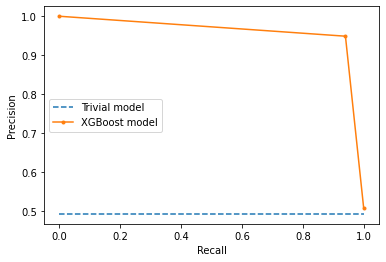

Confusion matrix:
 [[4914   53]
 [ 884 4149]]

Report:
               precision    recall  f1-score   support

           0       0.85      0.99      0.91      4967
           1       0.99      0.82      0.90      5033

    accuracy                           0.91     10000
   macro avg       0.92      0.91      0.91     10000
weighted avg       0.92      0.91      0.91     10000

test accuracy: 0.9063


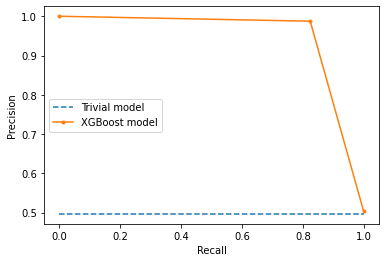




K value: 25
[0]	validation_0-logloss:0.53757
[1]	validation_0-logloss:0.42492
[2]	validation_0-logloss:0.34130
[3]	validation_0-logloss:0.28528
[4]	validation_0-logloss:0.23852
[5]	validation_0-logloss:0.19952
[6]	validation_0-logloss:0.17417
[7]	validation_0-logloss:0.15823
[8]	validation_0-logloss:0.14713
[9]	validation_0-logloss:0.14014
[10]	validation_0-logloss:0.12350
[11]	validation_0-logloss:0.10983
[12]	validation_0-logloss:0.10031
[13]	validation_0-logloss:0.09612
[14]	validation_0-logloss:0.08925
[15]	validation_0-logloss:0.08182
[16]	validation_0-logloss:0.07501
[17]	validation_0-logloss:0.06935
[18]	validation_0-logloss:0.06953
[19]	validation_0-logloss:0.06551
[20]	validation_0-logloss:0.06105
[21]	validation_0-logloss:0.05303
[22]	validation_0-logloss:0.05153
[23]	validation_0-logloss:0.04815
[24]	validation_0-logloss:0.04646
[25]	validation_0-logloss:0.04391
[26]	validation_0-logloss:0.04021
[27]	validation_0-logloss:0.03778
[28]	validation_0-logloss:0.03861
[29]	vali

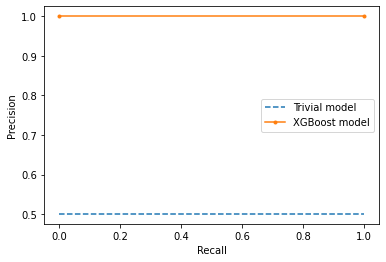

Confusion matrix:
 [[4907   14]
 [  66 5013]]

Report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99      4921
           1       1.00      0.99      0.99      5079

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000

val accuracy: 0.992


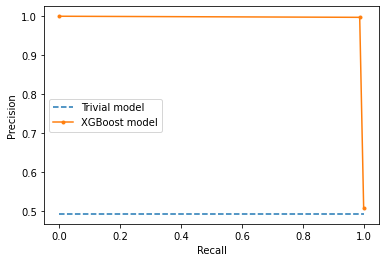

Confusion matrix:
 [[4956   11]
 [ 354 4679]]

Report:
               precision    recall  f1-score   support

           0       0.93      1.00      0.96      4967
           1       1.00      0.93      0.96      5033

    accuracy                           0.96     10000
   macro avg       0.97      0.96      0.96     10000
weighted avg       0.97      0.96      0.96     10000

test accuracy: 0.9635


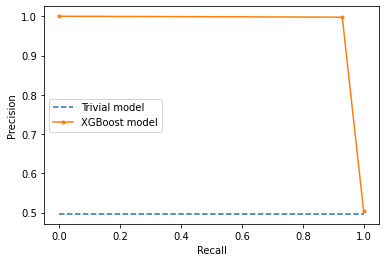




K value: 50
[0]	validation_0-logloss:0.53536
[1]	validation_0-logloss:0.43825
[2]	validation_0-logloss:0.35022
[3]	validation_0-logloss:0.30291
[4]	validation_0-logloss:0.25842
[5]	validation_0-logloss:0.21181
[6]	validation_0-logloss:0.18624
[7]	validation_0-logloss:0.15768
[8]	validation_0-logloss:0.13520
[9]	validation_0-logloss:0.11584
[10]	validation_0-logloss:0.10260
[11]	validation_0-logloss:0.09116
[12]	validation_0-logloss:0.08183
[13]	validation_0-logloss:0.07490
[14]	validation_0-logloss:0.06935
[15]	validation_0-logloss:0.06591
[16]	validation_0-logloss:0.06020
[17]	validation_0-logloss:0.05324
[18]	validation_0-logloss:0.04992
[19]	validation_0-logloss:0.04659
[20]	validation_0-logloss:0.04317
[21]	validation_0-logloss:0.04164
[22]	validation_0-logloss:0.04061
[23]	validation_0-logloss:0.03857
[24]	validation_0-logloss:0.03903
[25]	validation_0-logloss:0.03597
[26]	validation_0-logloss:0.03672
[27]	validation_0-logloss:0.03469
[28]	validation_0-logloss:0.03550
[29]	vali

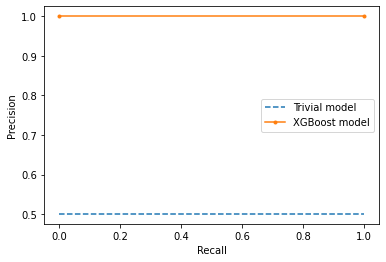

Confusion matrix:
 [[4861   60]
 [  67 5012]]

Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99      4921
           1       0.99      0.99      0.99      5079

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000

val accuracy: 0.9873


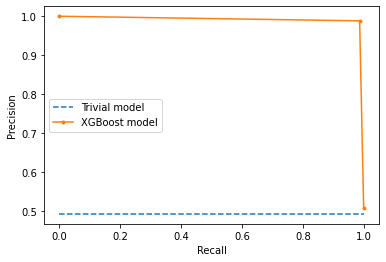

Confusion matrix:
 [[4966    1]
 [ 205 4828]]

Report:
               precision    recall  f1-score   support

           0       0.96      1.00      0.98      4967
           1       1.00      0.96      0.98      5033

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000

test accuracy: 0.9794


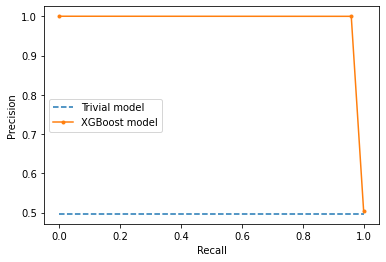




K value: 186
[0]	validation_0-logloss:0.53411
[1]	validation_0-logloss:0.43688
[2]	validation_0-logloss:0.36014
[3]	validation_0-logloss:0.30209
[4]	validation_0-logloss:0.25712
[5]	validation_0-logloss:0.22463
[6]	validation_0-logloss:0.19133
[7]	validation_0-logloss:0.16418
[8]	validation_0-logloss:0.14379
[9]	validation_0-logloss:0.12493
[10]	validation_0-logloss:0.11297
[11]	validation_0-logloss:0.10043
[12]	validation_0-logloss:0.08933
[13]	validation_0-logloss:0.08228
[14]	validation_0-logloss:0.07480
[15]	validation_0-logloss:0.06863
[16]	validation_0-logloss:0.06160
[17]	validation_0-logloss:0.05604
[18]	validation_0-logloss:0.05204
[19]	validation_0-logloss:0.04948
[20]	validation_0-logloss:0.04563
[21]	validation_0-logloss:0.04292
[22]	validation_0-logloss:0.03977
[23]	validation_0-logloss:0.03672
[24]	validation_0-logloss:0.03635
[25]	validation_0-logloss:0.03448
[26]	validation_0-logloss:0.03458
[27]	validation_0-logloss:0.03328
[28]	validation_0-logloss:0.03254
[29]	val

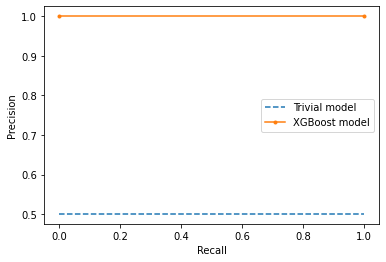

Confusion matrix:
 [[4918    3]
 [  69 5010]]

Report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99      4921
           1       1.00      0.99      0.99      5079

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000

val accuracy: 0.9928


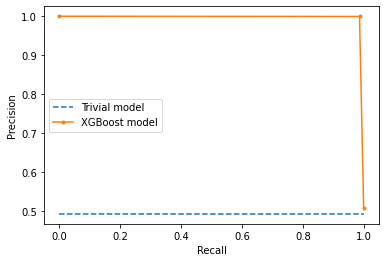

Confusion matrix:
 [[4967    0]
 [ 100 4933]]

Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99      4967
           1       1.00      0.98      0.99      5033

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000

test accuracy: 0.99


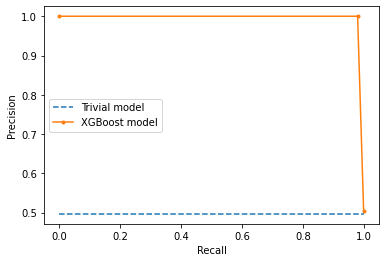

In [35]:
topkpeptide_models = try_model_on_top_k_peptides()

In [40]:
peptidoforms_intensity_df.shape

(40921, 351)

In [36]:
ft.shape

(40921,)

In [38]:
peptidoforms_intensity_df['model_weight'] = ft
peptidoforms_intensity_df.sort_values('model_weight')

,Peptidoform,Peptidoform ID,Unmod peptidoform,Total,Total- Unmodified sequence,Peptidoforms- Unmodified sequence,Proteins,Mass,Charge,Num Mods,...,Patient_57.Timepoint_6,Patient_57.Timepoint_7,Patient_58.Timepoint_1,Patient_58.Timepoint_2,Patient_58.Timepoint_3,Patient_58.Timepoint_4,Patient_58.Timepoint_5,Patient_58.Timepoint_6,Patient_58.Timepoint_7,model_weight
0,.SPLFM+15.995GK.,SPLFM+15.995GK,.SPLFMGK.,11679,11681,2,sp|P01009|A1AT_HUMAN;tr|A0A024R6I7|A0A024R6I7_...,795.4060,2,1,...,3.107250e+09,4.155225e+09,3.817200e+09,6.073900e+09,6.265175e+09,6.710850e+09,6.563850e+09,4.345225e+09,4.934400e+09,0.000000
27277,.+107.998C+57.021C+57.021EKPLLE+53.919KSHC+57....,+107.998C+57.021C+57.021EKPLLE+53.919KSHC+57.0...,.CCEKPLLEKSHCIAEVENDEMPADLPSLAADFVESK.,2,552,62,sp|P02768-2|ALBU_HUMAN;sp|P02768|ALBU_HUMAN;tr...,4294.8180,4,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
27278,.+10.76TVLLLTIC+57.021SLEGALVRRQAKEPC+57.021VE...,+10.76TVLLLTIC+57.021SLEGALVRRQAKEPC+57.021VES...,.TVLLLTICSLEGALVRRQAKEPCVESLVSQYFQTVTDYGK.,2,58,27,sp|P02652|APOA2_HUMAN;tr|V9GYC1|V9GYC1_HUMAN;t...,4583.1467,3,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
27279,.-1.03VVSVLTVVHQDWLNGK.,-1.03VVSVLTVVHQDWLNGK,.VVSVLTVVHQDWLNGK.,2,10593,81,sp|P01859|IGHG2_HUMAN;tr|A0A286YEY4|A0A286YEY4...,1792.9608,2,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
27280,.-1.03VVHFIYIAILSQK.,-1.03VVHFIYIAILSQK,.VVHFIYIAILSQK.,2,6,4,sp|P43652|AFAM_HUMAN,1529.8773,2,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6518,.+57.021QTALVELVK.,+57.021QTALVELVK,.QTALVELVK.,29,12508,56,sp|P02768-2|ALBU_HUMAN;sp|P02768-3|ALBU_HUMAN;...,1057.6342,2,1,...,NaN,NaN,5.801600e+07,6.908733e+07,6.981700e+07,6.371067e+07,8.551600e+07,5.983867e+07,8.922300e+07,0.041673
1845,.L-14.016LIYDASNLETGVPSR.,L-14.016LIYDASNLETGVPSR,.LLIYDASNLETGVPSR.,280,2632,70,sp|P01593|KVD33_HUMAN;sp|P01594|KV102_HUMAN;tr...,1733.9112,2,1,...,3.003900e+07,2.291007e+07,7.616800e+07,6.521100e+07,6.333133e+07,5.541200e+07,6.351450e+07,5.780767e+07,5.982500e+07,0.042998
1549,.LLIY-15.995GASTR.,LLIY-15.995GASTR,.LLIYGASTR.,359,1851,32,sp|A0A0C4DH55|KVD07_HUMAN;sp|P01624|KV315_HUMA...,977.5770,2,1,...,4.535475e+07,4.766175e+07,5.173625e+07,5.952675e+07,5.928875e+07,5.061050e+07,7.400725e+07,3.747550e+07,5.938675e+07,0.066153
1854,.P-10.021GQAPVLVVYDDSDRPSGIPER.,P-10.021GQAPVLVVYDDSDRPSGIPER,.PGQAPVLVVYDDSDRPSGIPER.,278,1306,53,sp|P80748|LV302_HUMAN,2357.1978,3,1,...,4.050708e+07,3.782150e+07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.073149


In [39]:
peptidoforms_intensity_df.to_csv("peptidoforms_with_model_weights_may272021.csv", index=None)

### <font color='blue'>**Important peptides analysis**

In [38]:
def get_patients_peptide_is_present_in(peptide_index):
    present_patient_timepoints = peptidoforms_intensity_df.iloc[peptide_index, 32:].dropna().index
    
    patients = set()
    for pt in present_patient_timepoints:
        spltidx = pt.index(".Timepoint_")
        patient_id = int(pt[:spltidx].replace("Patient_", ""))
        patients.add(patient_id)
    
    return patients

In [39]:
def plot_binned_peptidoform_and_patient_counts(ft, bin_width=0.025, patient_agg="sum"):
    assert patient_agg in ("sum", "avg")
    
    # sorted_peptidoform_indices is sorted by ascending weights
    sorted_peptidoform_indices = ft.argsort()
    
    bins = []
    current_bins_first_peptidoform_weight = None
    
    for pep_idx in sorted_peptidoform_indices:
        pep_weight = ft[pep_idx]
                
        # should we add this pep idx to the current bin, or to a new one?
        if current_bins_first_peptidoform_weight is None or pep_weight - current_bins_first_peptidoform_weight  > bin_width:
            # Add this pep idx to a new bin
            new_bin = [pep_idx,]
            bins.append(new_bin)
            
            current_bins_first_peptidoform_weight = pep_weight
        else:
            # Add this pep idx to the current, latest bin
            bins[-1].append(pep_idx)
    
    avg_num_patients_per_bin = []
    num_patients_per_bin = []
    num_peptides_per_bin = []
    
    for bin_peptide_indices in bins:
        # bin_peptide_indices is the set of peptide indices in this bin
        # get the total, unique set of patients spanned across all the peptides in this bin
        
        # using sets ensures that the patients stay de-duplicated across the peptides
        patients_per_peptide_in_bin = [get_patients_peptide_is_present_in(pep_idx) for pep_idx in bin_peptide_indices]
        avg_num_patients_per_peptide_in_bin = sum([len(ps) for ps in patients_per_peptide_in_bin]) / len(patients_per_peptide_in_bin)
        avg_num_patients_per_bin.append(avg_num_patients_per_peptide_in_bin)
        
        all_patients_in_this_bin = set.union(*patients_per_peptide_in_bin)
        num_patients_per_bin.append(len(all_patients_in_this_bin))
        num_peptides_per_bin.append(len(bin_peptide_indices))
        
    # this plot style adapted from: https://matplotlib.org/stable/gallery/subplots_axes_and_figures/two_scales.html
    fig, ax1 = plt.subplots()

    plt.title("Peptidoform & patient counts")
    ax1.set_xlabel('Peptidoform importance weight')
    if patient_agg == "sum":
        ax1.set_ylabel('Number of patients')
        ax1.scatter([ft[b[0]] for b in bins], num_patients_per_bin)
    else:
        ax1.set_ylabel('Avg. # patients/peptide')
        ax1.scatter([ft[b[0]] for b in bins], avg_num_patients_per_bin)

    ax1.tick_params(axis='y')
    ax1.legend(["# patients"])

    ax2 = ax1.twinx()

    ax2.set_ylabel('Number of peptidoforms')  # we already handled the x-label with ax1
    ax2.bar([ft[b[0]] for b in bins], num_peptides_per_bin, width=0.01, align="center", fc=(0, 0, 1, 0.05))
    ax2.tick_params(axis='y')
    plt.ylim(top=100) # because there are thousands of peptides with low importance, this will improve the plot readability
    
    fig.tight_layout()
    plt.savefig("peptidoform_and_patient_counts.png", transparent=False)
    plt.show()

In [40]:
ft[ft.argsort()[-1]]

0.08659608

In [41]:
ft.argsort()[::-1]

array([ 3143,  1232,  2666, ..., 27279, 27278,     0])

In [42]:
peptidoforms_intensity_df.iloc[ft.argsort()[::-1]]

,Peptidoform,Peptidoform ID,Unmod peptidoform,Total,Total- Unmodified sequence,Peptidoforms- Unmodified sequence,Proteins,Mass,Charge,Num Mods,...,Patient_57.Timepoint_5,Patient_57.Timepoint_6,Patient_57.Timepoint_7,Patient_58.Timepoint_1,Patient_58.Timepoint_2,Patient_58.Timepoint_3,Patient_58.Timepoint_4,Patient_58.Timepoint_5,Patient_58.Timepoint_6,Patient_58.Timepoint_7
3143,.AGVETTTPS-15.995K.,AGVETTTPS-15.995K,.AGVETTTPSK.,117,7075,99,sp|P0DOY2|IGLC2_HUMAN;sp|P0DOY3|IGLC3_HUMAN,974.5150,2,1,...,1.863955e+07,1.429522e+07,1.965850e+07,2.587033e+07,3.086700e+07,3.162700e+07,2.996400e+07,3.344825e+07,1.720800e+07,2.756500e+07
1232,.YVLTQPPSVSVAPGQTAR-28.006.,YVLTQPPSVSVAPGQTAR-28.006,.YVLTQPPSVSVAPGQTAR.,478,1491,38,sp|P80748|LV302_HUMAN,1843.0038,2,1,...,5.676100e+07,6.249850e+07,4.782575e+07,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2666,.ASS+26.052LESGVPSR.,ASS+26.052LESGVPSR,.ASSLESGVPSR.,155,2883,49,sp|A0A0B4J2D9|KVD13_HUMAN;sp|P01602|KV105_HUMA...,1115.6127,2,1,...,4.276450e+07,4.031400e+07,3.772150e+07,3.335525e+07,4.672567e+07,4.963633e+07,4.341425e+07,5.046300e+07,3.229500e+07,4.550425e+07
3074,.GLEWVSGISW-29.978.,GLEWVSGISW-29.978,.GLEWVSGISW.,122,122,1,sp|P01782|HV309_HUMAN,1103.5847,2,1,...,NaN,1.647300e+07,NaN,2.309582e+07,2.252528e+07,2.578600e+07,2.178580e+07,3.040600e+07,2.646500e+07,3.037650e+07
2028,.LLLYAA-14.016SR.,LLLYAA-14.016SR,.LLLYAASR.,243,917,19,tr|A0A0G2JRQ6|A0A0G2JRQ6_HUMAN,892.5266,2,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27281,.-1.03MLEEIMKYEASILTHDSSIR.,-1.03MLEEIMKYEASILTHDSSIR,.MLEEIMKYEASILTHDSSIR.,2,1808,12,sp|P02679-2|FIBG_HUMAN;sp|P02679|FIBG_HUMAN;tr...,2365.1384,3,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
27280,.-1.03VVHFIYIAILSQK.,-1.03VVHFIYIAILSQK,.VVHFIYIAILSQK.,2,6,4,sp|P43652|AFAM_HUMAN,1529.8773,2,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
27279,.-1.03VVSVLTVVHQDWLNGK.,-1.03VVSVLTVVHQDWLNGK,.VVSVLTVVHQDWLNGK.,2,10593,81,sp|P01859|IGHG2_HUMAN;tr|A0A286YEY4|A0A286YEY4...,1792.9608,2,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
27278,.+10.76TVLLLTIC+57.021SLEGALVRRQAKEPC+57.021VE...,+10.76TVLLLTIC+57.021SLEGALVRRQAKEPC+57.021VES...,.TVLLLTICSLEGALVRRQAKEPCVESLVSQYFQTVTDYGK.,2,58,27,sp|P02652|APOA2_HUMAN;tr|V9GYC1|V9GYC1_HUMAN;t...,4583.1467,3,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


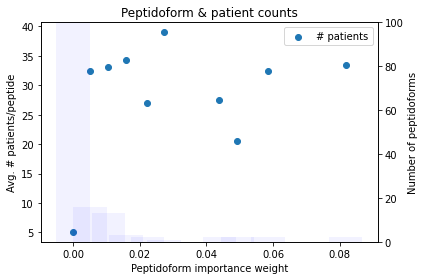

In [43]:
plot_binned_peptidoform_and_patient_counts(ft, bin_width=0.005, patient_agg="avg")

<AxesSubplot:>

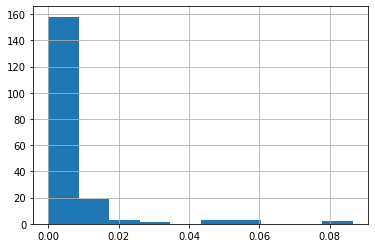

In [44]:
# x-axis is weight and y-axis is count
# this shows that very, very few peptides have a significant weight (ie., > 0.035)
pd.Series(ft[ft > 0]).hist()

In [45]:
# Because the first half of the features and the second half are semantically the same, 
# we have to % by the number of unique peptides (ie., the size of the first half of each combined feature vector)
# to get the unique set of peptides that are deemed important
important_peptide_indices = np.where(ft > 0)[0]
len(important_peptide_indices)

189

In [46]:
def get_patients_peptide_is_present_in(peptide_index):
    present_patient_timepoints = peptidoforms_intensity_df.iloc[peptide_index, 32:].dropna().index
    
    patients = set()
    for pt in present_patient_timepoints:
        spltidx = pt.index(".Timepoint_")
        patient_id = int(pt[:spltidx].replace("Patient_", ""))
        patients.add(patient_id)
    
    return patients

In [47]:
peptide_indices_with_counts = []
for peptide_index in important_peptide_indices:
    count = len(get_patients_peptide_is_present_in(peptide_index))
    peptide_indices_with_counts.append((peptide_index, count))
sorted(peptide_indices_with_counts, key = lambda item: item[1])

[(4770, 5),
 (10016, 9),
 (2033, 10),
 (10849, 11),
 (3908, 13),
 (6369, 14),
 (6566, 15),
 (8293, 15),
 (8384, 15),
 (22368, 15),
 (1783, 16),
 (6518, 16),
 (10343, 16),
 (3532, 17),
 (4369, 17),
 (6788, 17),
 (3600, 18),
 (5910, 18),
 (2895, 19),
 (5409, 19),
 (9065, 20),
 (778, 21),
 (3599, 21),
 (4131, 21),
 (11584, 21),
 (1315, 22),
 (3052, 22),
 (4636, 22),
 (5685, 22),
 (9532, 22),
 (1599, 23),
 (2028, 23),
 (2806, 23),
 (2997, 23),
 (3134, 24),
 (3257, 24),
 (4682, 24),
 (5475, 24),
 (3264, 25),
 (4748, 25),
 (5602, 25),
 (23746, 25),
 (123, 26),
 (995, 26),
 (1007, 26),
 (2438, 26),
 (2537, 26),
 (2701, 26),
 (3364, 26),
 (4888, 26),
 (5513, 26),
 (1722, 27),
 (1966, 27),
 (2217, 27),
 (2654, 27),
 (2785, 27),
 (7522, 27),
 (2366, 28),
 (2541, 28),
 (2577, 28),
 (3066, 28),
 (3116, 28),
 (3449, 28),
 (3794, 28),
 (4018, 28),
 (4124, 28),
 (4556, 28),
 (4565, 28),
 (1688, 29),
 (2464, 29),
 (3274, 29),
 (3402, 29),
 (3557, 29),
 (3790, 29),
 (4126, 29),
 (8440, 29),
 (3400, 30)

In [48]:
original_data_df = pd.read_csv(DATA_TSV_FILEPATH, sep="\t")
assert original_data_df.shape[0] == peptidoforms_intensity_df.shape[0]

/Users/subby/UCSD/CSE_291C/Projects/cse291c-plasma-weightloss/venv/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3170: DtypeWarning: Columns (38,42,44,48,52,56,92,98,102,108,116,122,124,126,128,130,132,134,138,140,144,146,148,150,152,154,156,176,184,190,196,200,212,216,228,234,236,238,242,244,246,248,250,252,254,256,258,260,262,264,268,270,272,274,284,286,288,290,292,294,296,298,300,302,304,306,308,310,312,314,316,318,322,324,330,332,334,336,338,340,342,344,346,350,364,372,374,378,380,382,388,390,392,394,398,404,406,408,410,412,414,416,426,428,440,444,446,454,458,460,464,466,468,484,502,510,514,516,522,524,526,528,538,540,542,544,552,554,556,558,562,576,592,606,608,610,612,618,622,624,626,628,630,632,640,642,644,646,650,652,654,656,658,660,662,664,674,676,678,684,686,692,694,696,698,700,702) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [49]:
original_data_df = original_data_df.iloc[important_peptide_indices]
original_data_df['model_weight'] = ft[important_peptide_indices]

In [50]:
original_data_df.to_csv("important_peptidoforms_selected_by_xgboost_all_columns.csv", index=None)

In [51]:
export_peptidoforms_intensity_df = peptidoforms_intensity_df.iloc[important_peptide_indices]
export_peptidoforms_intensity_df['model_weight'] = ft[important_peptide_indices]
export_peptidoforms_intensity_df.to_csv("important_peptidoforms_selected_by_xgboost.csv", index=None)

/Users/subby/UCSD/CSE_291C/Projects/cse291c-plasma-weightloss/venv/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [52]:
top_peptidoform_indices_and_weights = list(zip(important_peptide_indices, ft[important_peptide_indices]))
sorted(top_peptidoform_indices_and_weights, key = lambda item: item[1], reverse=True)

[(3143, 0.08659608),
 (1232, 0.081831954),
 (2666, 0.060263067),
 (3074, 0.05851912),
 (2028, 0.05292782),
 (3600, 0.049309306),
 (1845, 0.04753288),
 (6518, 0.04391777),
 (1549, 0.027326373),
 (6566, 0.022830034),
 (1701, 0.022295281),
 (2895, 0.019247726),
 (3445, 0.016957214),
 (910, 0.015968109),
 (3790, 0.015553942),
 (1867, 0.015098871),
 (4126, 0.0137367565),
 (2464, 0.0137072485),
 (1363, 0.013152749),
 (1113, 0.013077973),
 (1664, 0.012860667),
 (2318, 0.0123054655),
 (3856, 0.012008487),
 (3449, 0.011331956),
 (1783, 0.010930869),
 (23746, 0.010732628),
 (3329, 0.010622146),
 (2913, 0.010093788),
 (2945, 0.0099213105),
 (985, 0.0095301345),
 (3908, 0.0090529155),
 (340, 0.008336093),
 (3056, 0.0076952646),
 (1122, 0.0068824748),
 (1315, 0.006694156),
 (3599, 0.0065232716),
 (2577, 0.0064574126),
 (1995, 0.0063645476),
 (2041, 0.0060186777),
 (3054, 0.0059915087),
 (3443, 0.0058148387),
 (5475, 0.0056530386),
 (2712, 0.0051610037),
 (194, 0.0046776836),
 (3134, 0.0040678196),


### [Results] Do top selected peptides map to unique proteins or do they map to mutiple/shared proteins?

In [ ]:
peptidoforms_intensity_df